#### Explainability of BiLSTM using Attention

In [1]:
import os
import sys

if "google.colab" in sys.modules:
    workspace_dir = '/content/spam-detection'
    branch = 'feature/explainability-timing'
    current_dir = os.getcwd()
    if not os.path.exists(workspace_dir) and current_dir != workspace_dir:
        !git clone https://github.com/RationalEar/spam-detection.git
        os.chdir(workspace_dir)
        !git checkout $branch
        !ls -al
        !pip install -q transformers==4.48.0 scikit-learn pandas numpy lime
        !pip install -q torch --index-url https://download.pytorch.org/whl/cu126
        !pip install captum --no-deps --ignore-installed
    else:
        os.chdir(workspace_dir)
        !git pull origin $branch

    from google.colab import drive

    drive.mount('/content/drive')

Cloning into 'spam-detection'...
remote: Enumerating objects: 446, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 446 (delta 59), reused 71 (delta 33), pack-reused 331 (from 1)
Receiving objects: 100% (446/446), 5.68 MiB | 21.54 MiB/s, done.
Resolving deltas: 100% (217/217), done.
Branch 'feature/explainability-timing' set up to track remote branch 'feature/explainability-timing' from 'origin'.
Switched to a new branch 'feature/explainability-timing'
total 68
drwxr-xr-x 11 root root 4096 Aug 12 19:01 .
drwxr-xr-x  1 root root 4096 Aug 12 19:01 ..
-rw-r--r--  1 root root  584 Aug 12 19:01 docker-compose.yml
-rw-r--r--  1 root root  879 Aug 12 19:01 Dockerfile
-rw-r--r--  1 root root   92 Aug 12 19:01 .dockerignore
drwxr-xr-x  2 root root 4096 Aug 12 19:01 docs
drwxr-xr-x  2 root root 4096 Aug 12 19:01 explainability
drwxr-xr-x  8 root root 4096 Aug 12 19:01 .git
-rw-r--r--  1 root root   38 Aug 12 19:01 .gitignore
drw

In [2]:
import torch

import pandas as pd
from utils.constants import DATA_PATH, GLOVE_PATH

DATA_PATH

'/content/drive/MyDrive/Projects/spam-detection-data'

In [3]:
# Load the data
train_df = pd.read_pickle(DATA_PATH + '/data/processed/train.pkl')
test_df = pd.read_pickle(DATA_PATH + '/data/processed/test.pkl')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from utils.functions import set_seed, build_vocab

# Build vocabulary and load embeddings
set_seed(42)
word2idx, idx2word = build_vocab(train_df['text'])
embedding_dim = 300
max_len = 200

In [5]:
from preprocess.data_loader import load_glove_embeddings

pretrained_embeddings = load_glove_embeddings(GLOVE_PATH, word2idx, embedding_dim)

In [6]:
# Load the trained BiLSTM model
from models.bilstm import BiLSTMSpam

model_path = DATA_PATH + '/trained-models/spam_bilstm_final.pt'
model = BiLSTMSpam(vocab_size=len(word2idx), embedding_dim=embedding_dim,
                   pretrained_embeddings=pretrained_embeddings)
model.load(model_path, map_location=device)
model = model.to(device)
model.eval()

BiLSTMSpam(
  (embedding): Embedding(25245, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attention): Attention(
    (attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [7]:
from utils.functions import encode

# Prepare test data
X_test_tensor = torch.tensor([encode(t, word2idx, max_len) for t in test_df['text']])
y_test_tensor = torch.tensor(test_df['label'].values, dtype=torch.float32)

# Move data to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [8]:
# Get model predictions
with torch.no_grad():
    model_output = model(X_test_tensor)
    # If model returns a tuple, use the first element (typically the predictions)
    if isinstance(model_output, tuple):
        y_pred_probs = model_output[0]
    else:
        y_pred_probs = model_output

    y_pred = (y_pred_probs > 0.5).float()

In [9]:
samples = (150, 357, 402 , 416, 417, 604)
# display elements in the test set with the given indices
sample_df = test_df.iloc[list(samples)]
sample_df

,subject,text,label,source,sender_hash,reply_to_hash,date
150,Seeing is believing,seeing believing url <URL> author linda grant ...,0,easy_ham,e48634bb48df81f58894dfa459d8d363a55131ad80d90b...,,"Tue, 08 Oct 2002 08:01:07 -0000"
357,Apple Store eNews : November 2002,apple store enews november 2002 you appear usi...,0,hard_ham,44a1c8b4d70359a608e144a7037dd2c597de0c2a7e0687...,dc767a94b1b1941f8a66e2fd63d192f5bc284dabe81262...,"Wed, 27 Nov 2002 21:12:33 -0800"
402,RE: [ILUG] NVIDIA and Debian Woody,re ilug nvidia debian woody hi there now proba...,0,easy_ham_2,59681d3ae2f9791cb6b5dbc03c79f9f85d24779a117cb2...,,"Wed, 04 Dec 2002 04:05:38 -0600"
416,The Flight to Safety is Upon Us,flight safety upon us s not rush hour traffic ...,1,spam,559aee171ea8552beaf0f2b5558e92ffb8783618238bf1...,,"Sun, 15 Sep 2002 19:18:58 -0400"
417,Low cost quality conference calls,method post enctype text plain> name web addre...,1,spam,a2d18e9f5faf44a66cf6aef8e80caa162ddfcbe4b7ea4b...,,"Sun, 15 Sep 2002 06:55:37 -1900"
604,Cannabis Difference,cannabis difference mid summer customer apprec...,1,spam_2,f676dd05f5fb775ee673641fbd40658745176497d83e2a...,379a3703ef116c1d270d9c2e68e5b08f13a42188d5973c...,"Wed, 05 Aug 2020 04:01:50 -1900"


#### BiLSTM Explanation Quality Metrics Using LIME


Explaining easy_ham email: Seeing is believing
Explanation time: 3.36 seconds


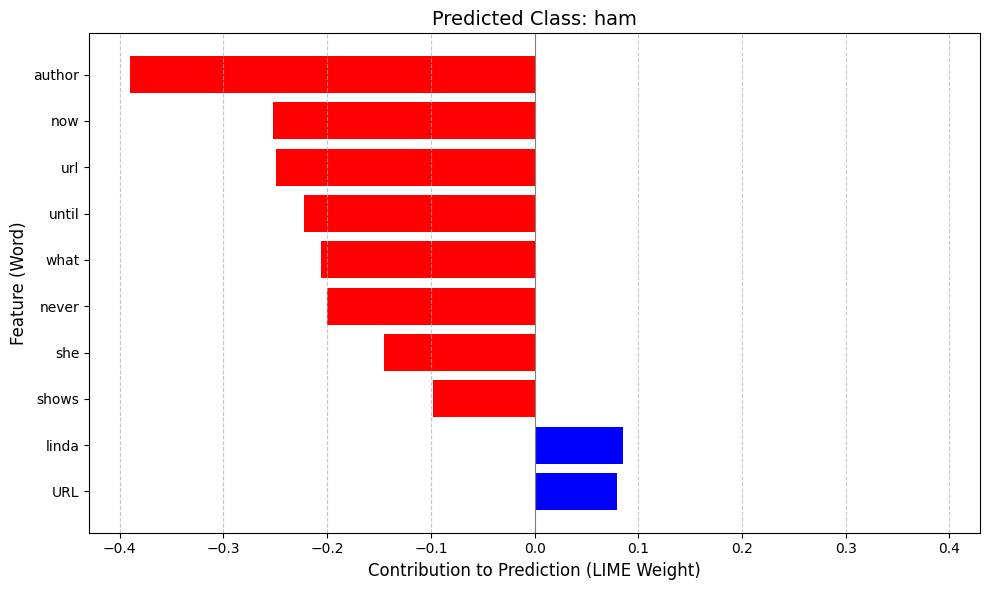


Explaining hard_ham email: Apple Store eNews : November 2002
Explanation time: 3.91 seconds


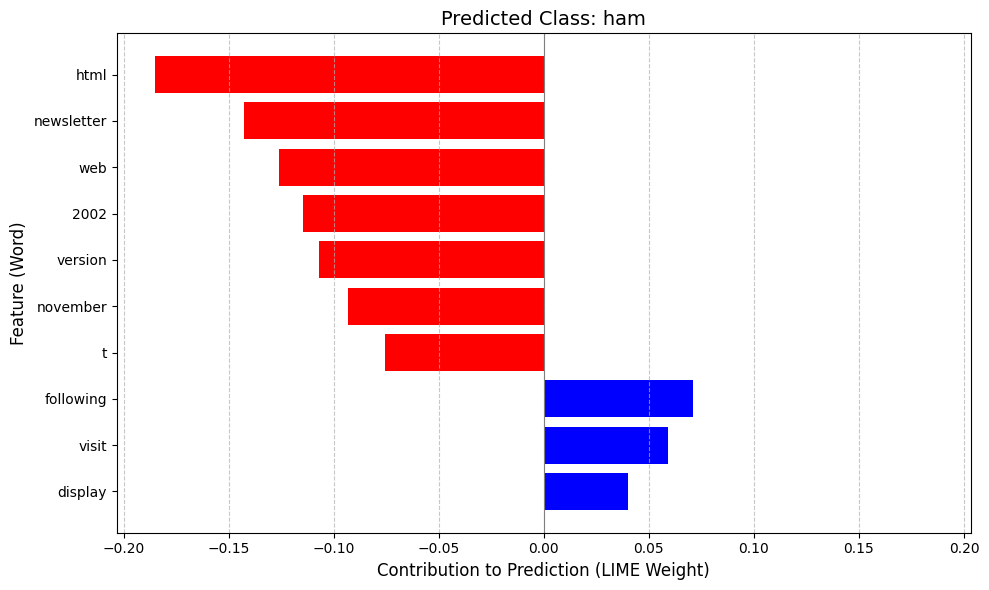


Explaining easy_ham_2 email: RE: [ILUG] NVIDIA and Debian Woody
Explanation time: 26.37 seconds


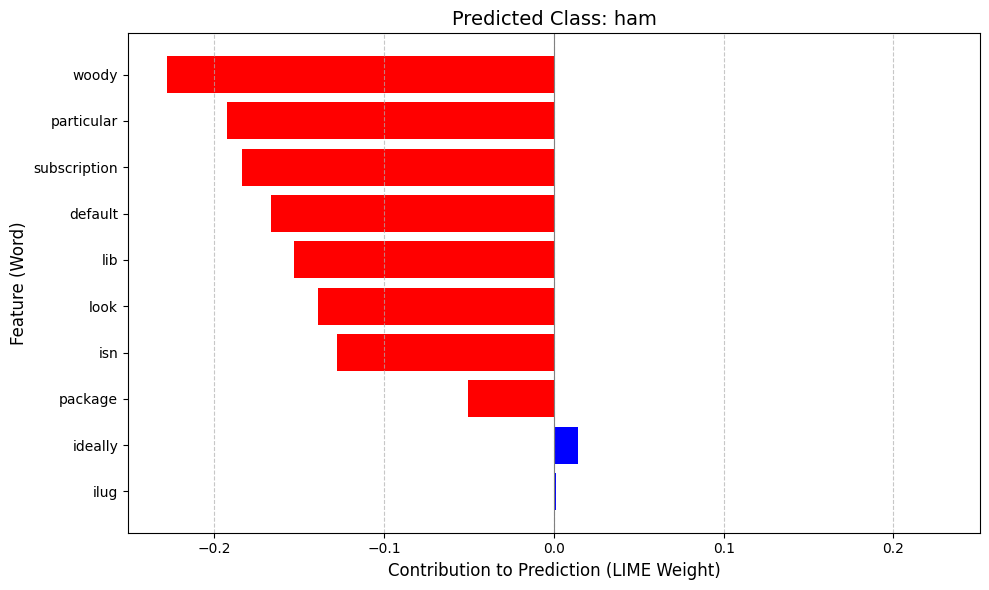


Explaining spam email: The Flight to Safety is Upon Us
Explanation time: 7.53 seconds


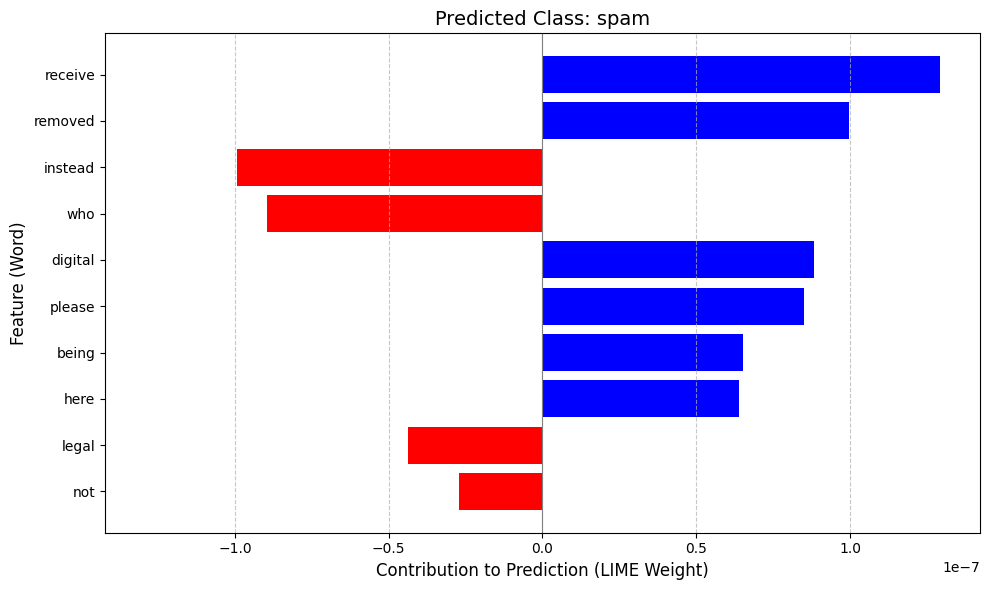


Explaining spam email: Low cost quality conference calls
Explanation time: 3.66 seconds


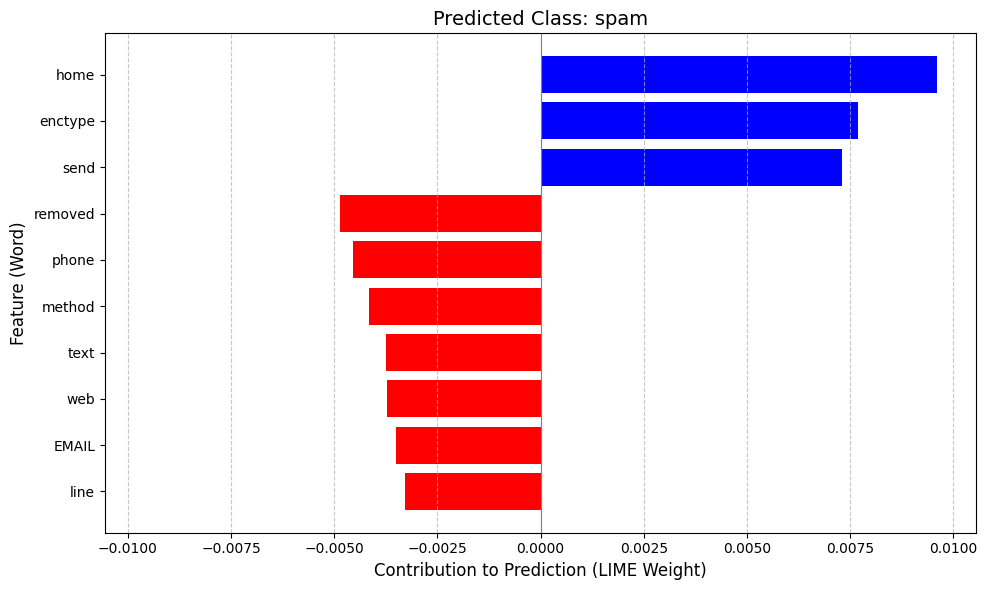


Explaining spam_2 email: Cannabis Difference
Explanation time: 127.35 seconds


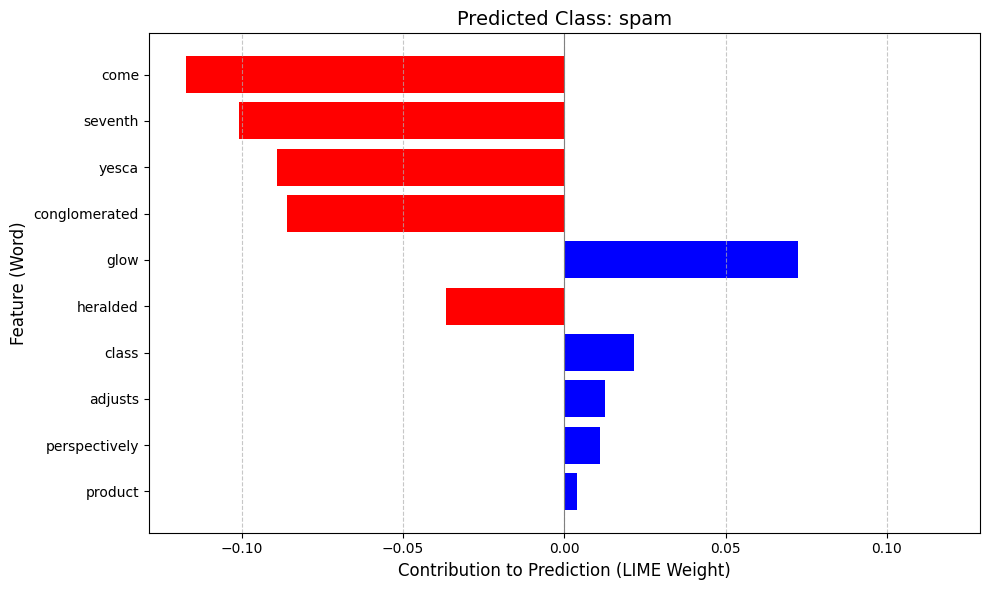

In [10]:
import numpy as np
from explainability.BiLSTMLimeExplainer import get_lime_explanation, plot_lime_explanation

class_names = ['ham', 'spam']
explanations = []
explanation_times = []
for i in samples:
    print(f"\nExplaining {test_df['source'].iloc[i]} email: {test_df['subject'].iloc[i]}")
    start_time = pd.Timestamp.now()
    explanation = get_lime_explanation(
        model,
        test_df['text'].iloc[i],
        word2idx,
        idx2word,
        num_samples=500,
        alpha=0.01
    )
    end_time = pd.Timestamp.now()
    explanation_times.append((end_time - start_time).total_seconds())
    explanations.append({
        'index': i,
        'label': test_df['label'].iloc[i],
        'text': test_df['text'].iloc[i],
        'explanation': explanation,
        'predicted_class': class_names[np.argmax(explanation.predict_proba)],
        'subject': test_df['subject'].iloc[i],
        'source': test_df['source'].iloc[i]
    })
    print(f"Explanation time: {explanation_times[-1]:.2f} seconds")
    plot_lime_explanation(explanation.as_list(), f"Predicted Class: {class_names[np.argmax(explanation.predict_proba)]}")


In [11]:
# create explanation time data frame
explanation_time_df = pd.DataFrame(explanation_times)
explanation_time_df.describe()

,0
count,6.000000
mean,28.697394
std,49.132767
min,3.356719
25%,3.722354
50%,5.718932
75%,21.663708
max,127.354317


In [12]:
explanations_df = pd.DataFrame(explanations)
explanations_df.set_index('index', inplace=True)
explanations_df

,label,text,explanation,predicted_class,subject,source
index,,,,,,
150,0,seeing believing url <URL> author linda grant ...,<lime.explanation.Explanation object at 0x7cb9...,ham,Seeing is believing,easy_ham
357,0,apple store enews november 2002 you appear usi...,<lime.explanation.Explanation object at 0x7cb9...,ham,Apple Store eNews : November 2002,hard_ham
402,0,re ilug nvidia debian woody hi there now proba...,<lime.explanation.Explanation object at 0x7cb9...,ham,RE: [ILUG] NVIDIA and Debian Woody,easy_ham_2
416,1,flight safety upon us s not rush hour traffic ...,<lime.explanation.Explanation object at 0x7cb9...,spam,The Flight to Safety is Upon Us,spam
417,1,method post enctype text plain> name web addre...,<lime.explanation.Explanation object at 0x7cb8...,spam,Low cost quality conference calls,spam
604,1,cannabis difference mid summer customer apprec...,<lime.explanation.Explanation object at 0x7cb7...,spam,Cannabis Difference,spam_2



Computing metrics for 0 sample 150: Seeing is believing
Metrics computed in 12.25 seconds
Plotting deletion and insertion curves for sample 150


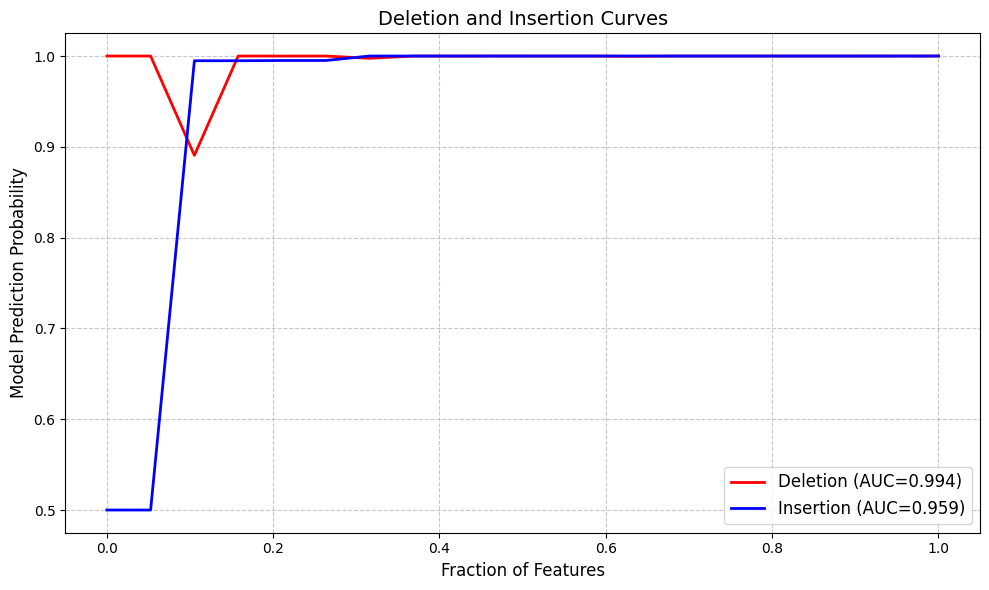


Computing metrics for 0 sample 357: Apple Store eNews : November 2002
Metrics computed in 16.65 seconds
Plotting deletion and insertion curves for sample 357


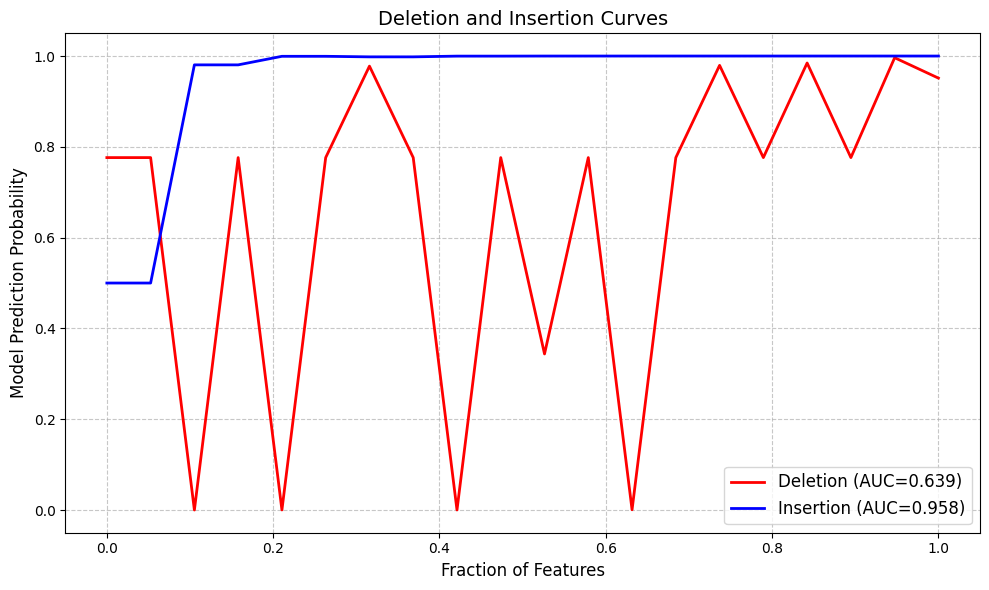


Computing metrics for 0 sample 402: RE: [ILUG] NVIDIA and Debian Woody
Metrics computed in 109.82 seconds
Plotting deletion and insertion curves for sample 402


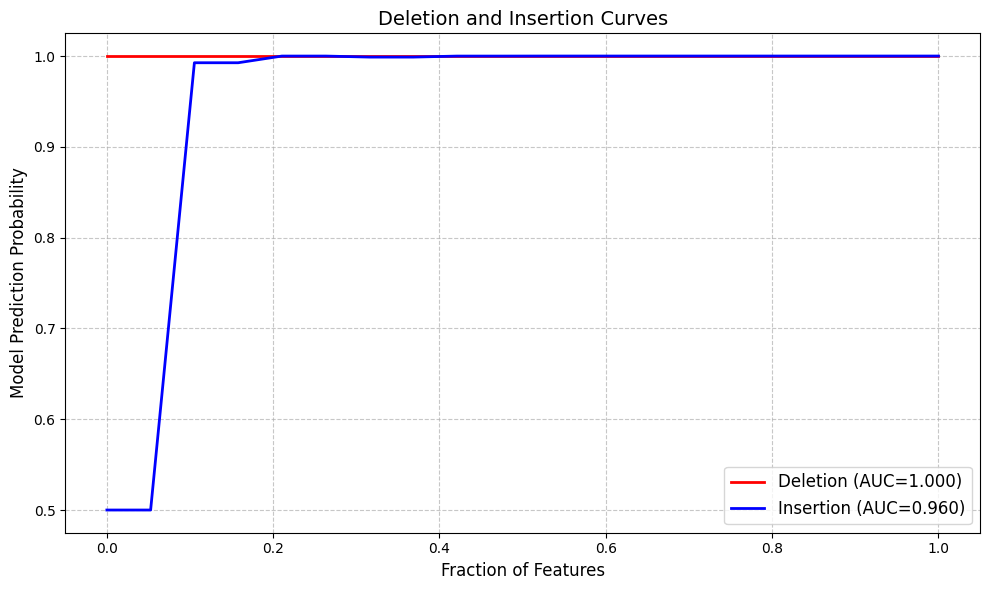


Computing metrics for 1 sample 416: The Flight to Safety is Upon Us
Metrics computed in 32.94 seconds
Plotting deletion and insertion curves for sample 416


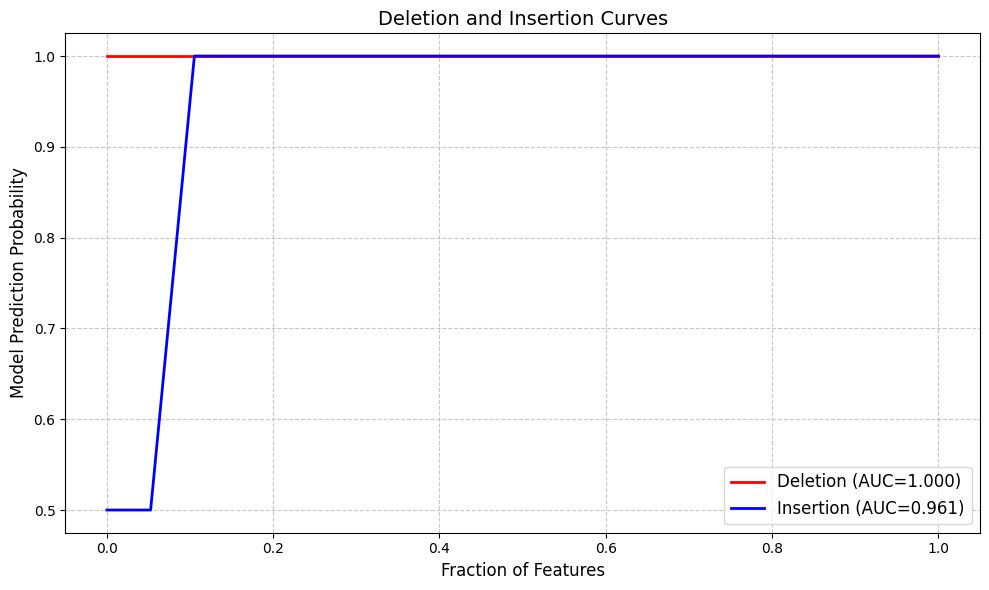


Computing metrics for 1 sample 417: Low cost quality conference calls
Metrics computed in 15.35 seconds
Plotting deletion and insertion curves for sample 417


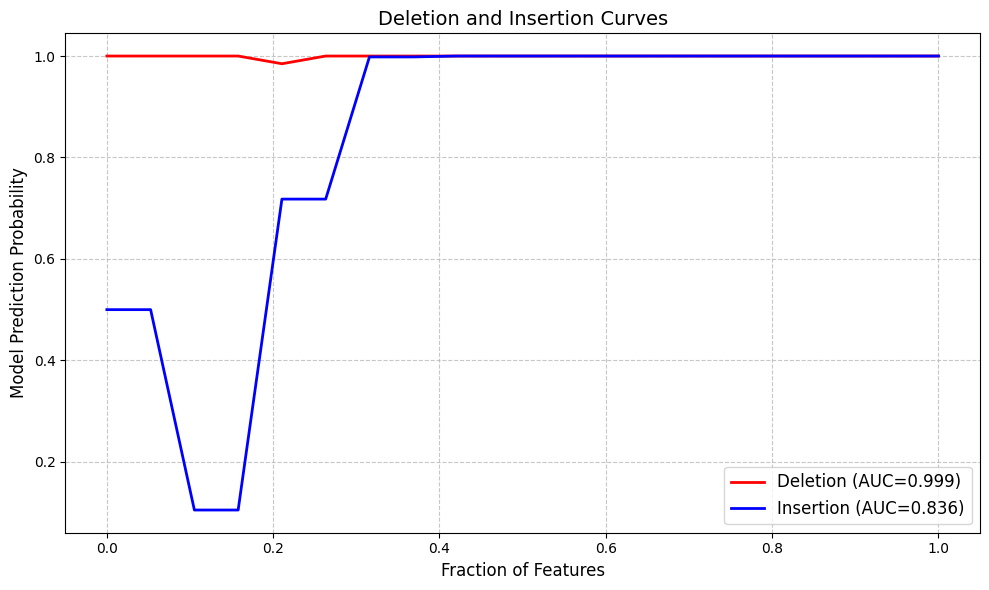


Computing metrics for 1 sample 604: Cannabis Difference
Metrics computed in 506.84 seconds
Plotting deletion and insertion curves for sample 604


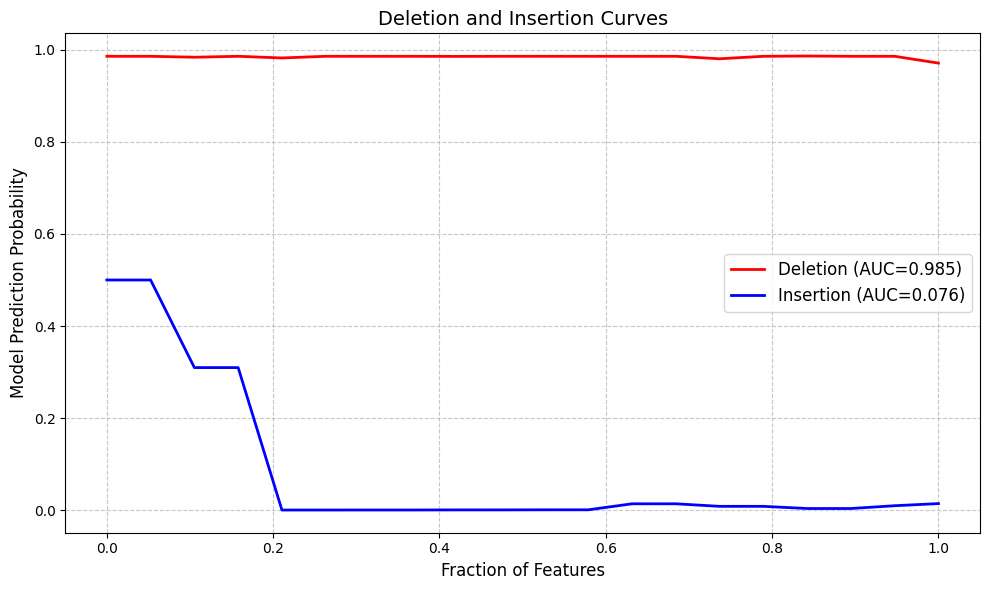

In [13]:
from explainability.BiLSTMLimeExplainer import (
    compute_auc_deletion, compute_auc_insertion, compute_comprehensiveness,
    compute_jaccard_stability, plot_deletion_insertion_curves, plot_metrics_across_samples,
    BiLSTMLimeExplainer, get_lime_explanation
)
# Create the wrapper for model predictions
explainer_wrapper = BiLSTMLimeExplainer(
    model,
    word2idx,
    idx2word,
    str(device)
)

# Let's calculate metrics for each sample and store them
metrics_results = []

for index, sample in explanations_df.iterrows():
    print(f"\nComputing metrics for {sample['label']} sample {index}: {sample['subject']}")

    # Text to explain
    text = sample['text']
    explanation = sample['explanation']

    # Calculate metrics
    start_time = pd.Timestamp.now()
    auc_del = compute_auc_deletion(explainer_wrapper, explanation, text)
    auc_del_time = (pd.Timestamp.now() - start_time).total_seconds()
    auc_ins_start_time = pd.Timestamp.now()
    auc_ins = compute_auc_insertion(explainer_wrapper, explanation, text)
    auc_ins_time = (pd.Timestamp.now() - auc_ins_start_time).total_seconds()
    comprehens_start_time = pd.Timestamp.now()
    comprehensiveness = compute_comprehensiveness(explainer_wrapper, explanation, text, k=5)
    comprehensiveness_time = (pd.Timestamp.now() - comprehens_start_time).total_seconds()

    # For Jaccard stability, we need similar inputs
    # For text, this is tricky - we'll use a simple approach of taking the current sample
    # and creating variations by removing random words
    # This is a very simplistic approach - in practice, you might want to use
    # techniques like synonym replacement, word dropout, etc.

    # Create slightly modified versions of the text
    import random
    random.seed(42)  # For reproducibility
    tokens = text.split()
    similar_texts = [text]  # Include the original text

    stability_start_time = pd.Timestamp.now()
    # Create 3 variations by removing 10% of words randomly
    for _ in range(3):
        num_to_remove = max(1, int(len(tokens) * 0.1))
        indices_to_remove = random.sample(range(len(tokens)), num_to_remove)
        modified_tokens = [tokens[i] for i in range(len(tokens)) if i not in indices_to_remove]
        similar_texts.append(' '.join(modified_tokens))

    stability = compute_jaccard_stability(
        model,
        similar_texts,
        word2idx,
        idx2word,
        num_features=5
    )
    end_time = pd.Timestamp.now()
    stability_time = (end_time - stability_start_time).total_seconds()
    print(f"Metrics computed in {(end_time - start_time).total_seconds():.2f} seconds")

    metrics_results.append({
        'Sample': index,
        'Subject': sample['subject'],
        'AUC-Del': auc_del,
        'AUC-Ins': auc_ins,
        'Comprehensiveness': comprehensiveness,
        'Jaccard Stability': stability,
        'AUC-Del Time (s)': auc_del_time,
        'AUC-Ins Time (s)': auc_ins_time,
        'Comprehensiveness Time (s)': comprehensiveness_time,
        'Stability Time (s)': stability_time,
        'Metric Computation Time (s)': (end_time - start_time).total_seconds()
    })

    # Plot deletion and insertion curves for this sample
    print(f"Plotting deletion and insertion curves for sample {index}")
    plot_deletion_insertion_curves(explainer_wrapper, explanation, text)

# Create a DataFrame from the metrics results
metrics_df = pd.DataFrame(metrics_results)
metrics_df.set_index('Sample', inplace=True)

In [14]:
metrics_df

,Subject,AUC-Del,AUC-Ins,Comprehensiveness,Jaccard Stability,AUC-Del Time (s),AUC-Ins Time (s),Comprehensiveness Time (s),Stability Time (s),Metric Computation Time (s)
Sample,,,,,,,,,,
150,Seeing is believing,0.994083,0.959462,0.999983,0.777778,0.163234,0.121980,0.016384,11.944202,12.245976
357,Apple Store eNews : November 2002,0.638594,0.958197,0.776279,0.251323,0.222749,0.125534,0.022108,16.274805,16.645374
402,RE: [ILUG] NVIDIA and Debian Woody,1.000000,0.959616,0.000000,0.055556,1.611615,0.262368,0.158448,107.791556,109.824185
416,The Flight to Safety is Upon Us,1.000000,0.960526,0.000000,0.292989,0.459318,0.154425,0.045779,32.281092,32.940811
417,Low cost quality conference calls,0.999199,0.836435,0.399369,0.210317,0.199489,0.128226,0.019633,15.001544,15.349057
604,Cannabis Difference,0.985215,0.075720,0.006443,0.055556,8.049511,0.902695,0.801506,497.089294,506.843365


In [15]:
metrics_df.describe()

,AUC-Del,AUC-Ins,Comprehensiveness,Jaccard Stability,AUC-Del Time (s),AUC-Ins Time (s),Comprehensiveness Time (s),Stability Time (s),Metric Computation Time (s)
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.936182,0.791660,0.363679,0.273920,1.784319,0.282538,0.177310,113.397082,115.641461
std,0.145899,0.354173,0.440122,0.266142,3.118211,0.308433,0.310523,191.435652,195.172532
min,0.638594,0.075720,0.000000,0.055556,0.163234,0.121980,0.016384,11.944202,12.245976
25%,0.987432,0.866876,0.001611,0.094246,0.205304,0.126207,0.020252,15.319859,15.673136
50%,0.996641,0.958830,0.202906,0.230820,0.341033,0.141325,0.033944,24.277949,24.793093
75%,0.999800,0.959578,0.682052,0.282573,1.323541,0.235382,0.130281,88.913940,90.603341
max,1.000000,0.960526,0.999983,0.777778,8.049511,0.902695,0.801506,497.089294,506.843365
